In [3]:
pip install shap

     |████████████████████████████████| 358kB 16.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=5f7a004520171670be597f4cbc2a7693f3cd8c4968ca2c848a1f2d766fad2cc0
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [4]:

#Import Starter Packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import xgboost as xgb
from xgboost import XGBClassifier
import shap

#Import sklearn 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE 
from sklearn import metrics

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#Import Dataset 
#Working Directory is already set correctly so it does not need to be added to the code
path = '/content/gdrive/MyDrive/risk_factors_cervical_cancer.csv'
df_rf = pd.read_csv(path)
df_rf.tail()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
853,34,3,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,?,?,0,0,0,0,0,0,0,0
854,32,2,19,1,0,0,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,?,?,0,0,0,0,0,0,0,0
855,25,2,17,0,0,0,0,1,0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,?,?,0,0,0,0,0,0,1,0
856,33,2,24,2,0,0,0,1,0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,?,?,0,0,0,0,0,0,0,0
857,29,2,20,1,0,0,0,1,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,?,?,0,0,0,0,0,0,0,0


In [7]:
#Drop the required columns as stated in the assignment outline 
df = df_rf.drop(columns = ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 'Schiller', 'Citology', 'Hinselmann'])

#Create the target variable (Biopsy)
target = df['Biopsy'].astype(float)
df.head()

#Split into X and Y variables 
X = df[['Age','Number of sexual partners','First sexual intercourse','Num of pregnancies','Smokes (years)', 'Smokes (packs/year)',
        'Hormonal Contraceptives (years)','IUD (years)','STDs (number)','STDs: Number of diagnosis', 'Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs:condylomatosis',	
        'STDs:cervical condylomatosis',	 'STDs:vaginal condylomatosis',	'STDs:vulvo-perineal condylomatosis',	'STDs:syphilis',	'STDs:pelvic inflammatory disease',
        'STDs:genital herpes',	'STDs:molluscum contagiosum',	'STDs:AIDS',	'STDs:HIV',	'STDs:Hepatitis B',	'STDs:HPV',
        'Dx:Cancer',	'Dx:CIN',	'Dx:HPV',	'Dx']]
X = X.replace('?', float('NaN'))
y = target

In [8]:
#Seperate the variable headers into Binary and continuous, as this will make it easier. They will just be subsets of the main df X 

cont = X[['Age','Number of sexual partners','First sexual intercourse','Num of pregnancies','Smokes (years)', 'Smokes (packs/year)',
        'Hormonal Contraceptives (years)','IUD (years)','STDs (number)','STDs: Number of diagnosis']]
bin = X[['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs:condylomatosis',	'STDs:cervical condylomatosis',	
        'STDs:vaginal condylomatosis',	'STDs:vulvo-perineal condylomatosis',	'STDs:syphilis',	'STDs:pelvic inflammatory disease',
        'STDs:genital herpes',	'STDs:molluscum contagiosum',	'STDs:AIDS',	'STDs:HIV',	'STDs:Hepatitis B',	'STDs:HPV',
        'Dx:Cancer',	'Dx:CIN',	'Dx:HPV',	'Dx']]

In [9]:
#Impute X (Continuous) as mean, and X(Binary) as mode

#Continuous Impute
continuous = SimpleImputer(missing_values=np.nan, strategy='mean')
continuous.fit(cont)
con = continuous.transform(cont)
#Binary Impute
Binary = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
Binary.fit(bin)
binn = Binary.transform(bin)
#
Cont = pd.DataFrame(con)
Cont.columns = ['Age','Number of sexual partners','First sexual intercourse','Num of pregnancies','Smokes (years)', 'Smokes (packs/year)',
        'Hormonal Contraceptives (years)','IUD (years)','STDs (number)','STDs: Number of diagnosis']
Bin = pd.DataFrame(binn)
Bin.columns = ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs:condylomatosis',	'STDs:cervical condylomatosis',	
        'STDs:vaginal condylomatosis',	'STDs:vulvo-perineal condylomatosis',	'STDs:syphilis',	'STDs:pelvic inflammatory disease',
        'STDs:genital herpes',	'STDs:molluscum contagiosum',	'STDs:AIDS',	'STDs:HIV',	'STDs:Hepatitis B',	'STDs:HPV',
        'Dx:Cancer',	'Dx:CIN',	'Dx:HPV',	'Dx']

In [10]:
#Now that the variables have been imputed in their respective ways, we can concatenate the dataframes together to recreate the original dataframe. 

X_clean = pd.concat([Cont, Bin], axis = 1) 
X_clean.head()
X_clean.shape
X_clean = X_clean.values
y = y.values

In [11]:
X_clean = X_clean.astype(float)

In [12]:
#Now we can split the data into a train/test split of 70% train to 30% test 

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.3)

In [13]:
#Using SMOTE to oversample 70% of the minority in terms of the majority 

oversample = SMOTE(sampling_strategy=0.7, k_neighbors=1)
X_train_sample, y_train_sample = oversample.fit_resample(X_train, y_train)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [14]:
#Create an XGBoost model and train it on the altered training data 

model = XGBClassifier()
fit = model.fit(X_train_sample, y_train_sample)
y_pred = fit.predict(X_test)

#Print metrics for the xgboost model
print("Accuracy", metrics.accuracy_score(y_test, y_pred))
print("F1 Score", metrics.f1_score(y_test, y_pred))
print("Precision", metrics.precision_score(y_test, y_pred))
print("Recall", metrics.recall_score(y_test, y_pred))
y_pred_proba = fit.predict_proba(X_test)[::,1]
print("AUC", metrics.roc_auc_score(y_test, y_pred_proba))

Accuracy 0.9069767441860465
F1 Score 0.19999999999999998
Precision 0.375
Recall 0.13636363636363635
AUC 0.6100731895223421


In [15]:
#Using SHAP to create the plots 
explainer = shap.TreeExplainer(fit)
shap_values = explainer.shap_values(X_test)
print(np.shape(shap_values), shap_values)

(258, 30) [[-0.25940672 -0.2407974   0.2256295  ...  0.         -0.01493843
  -0.35672486]
 [-0.26840732 -0.25374764  0.21206714 ...  0.         -0.01391116
  -0.3523954 ]
 [-0.03003515 -0.08416433 -0.4758819  ...  0.         -0.01479291
  -0.34647658]
 ...
 [ 0.15888783 -0.45626938 -0.15215184 ...  0.         -0.00903269
  -0.26706207]
 [-0.27554804 -0.23489165 -1.2876242  ...  0.         -0.01493843
  -0.3468775 ]
 [ 0.03059472  0.49336442 -0.21566288 ...  0.         -0.00903269
  -0.22159779]]


In [16]:
#Printout for a sample of the X_test data 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test[4])

In [17]:
#Printout for all of the X_test data 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

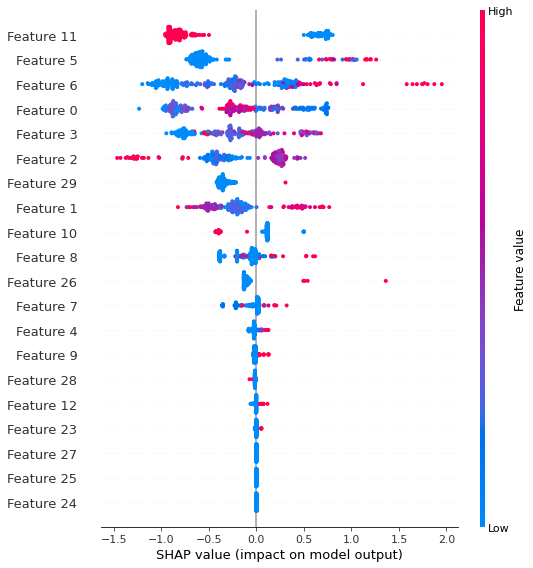

In [18]:
# SHAP Summary Plot 
shap.summary_plot(shap_values, X_test)